In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain
from modelingtools import (plot_cv_indices, cross_validate_alpha)

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, r2_score

import os
import seaborn as sns
import matplotlib.collections as clt
import ptitprince as pt

import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn import cross_validation as cv
import csv

/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import list of subjects
s_list = pd.read_csv('/Volumes/LBCN8T_2/Stanford/data/encoding/subject_list.csv')

In [3]:
s_list.shape[0]

57

KeyboardInterrupt: 

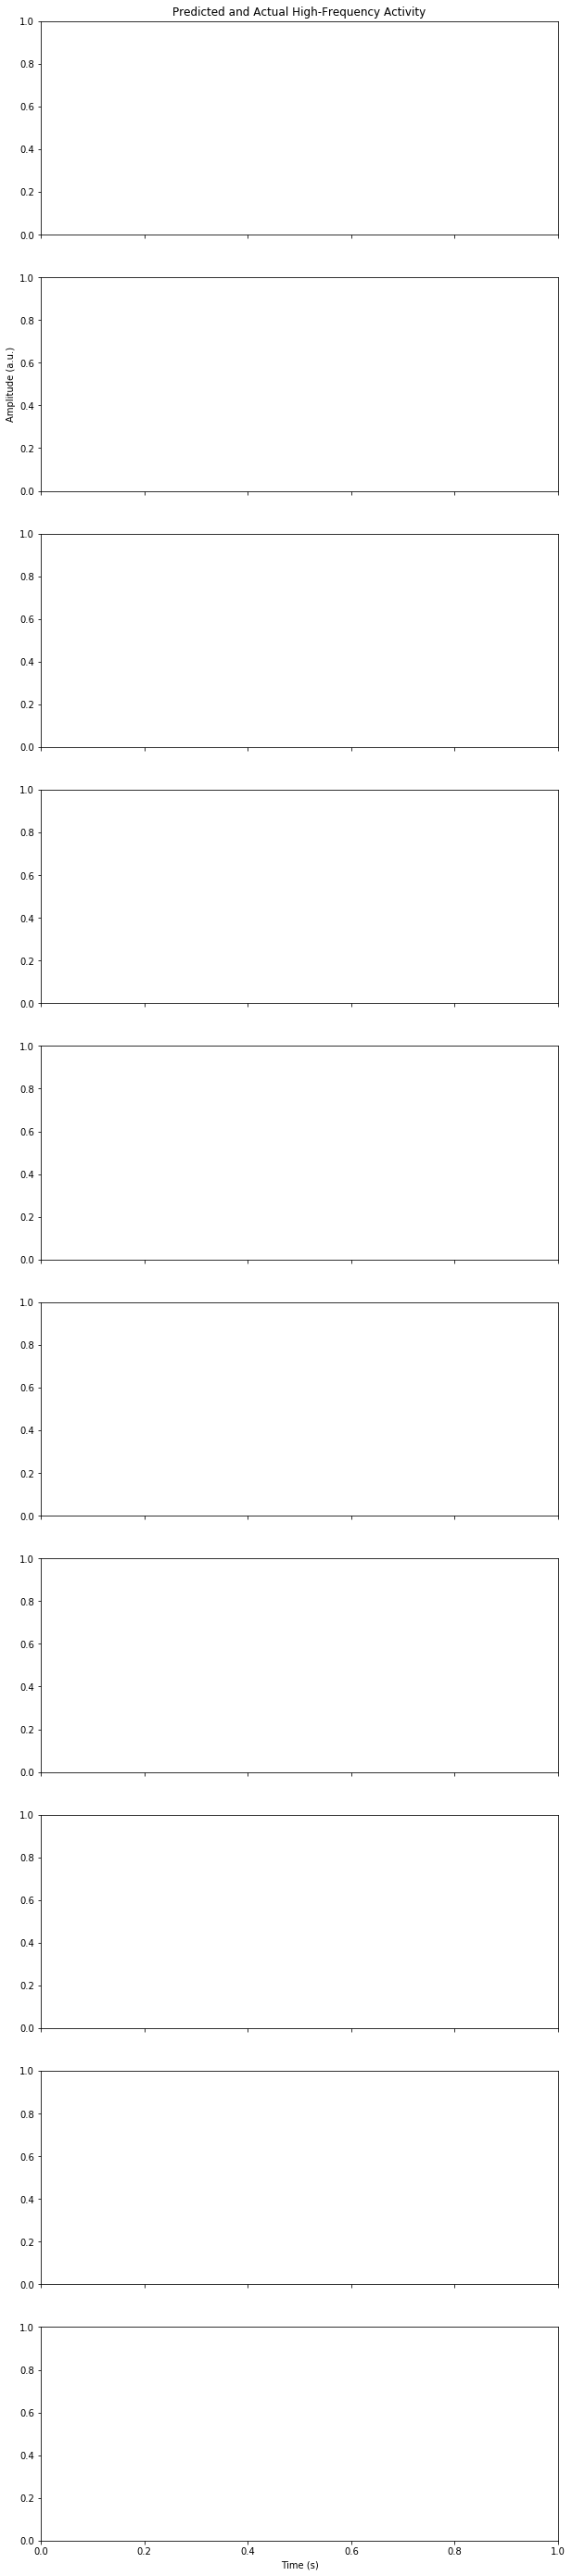

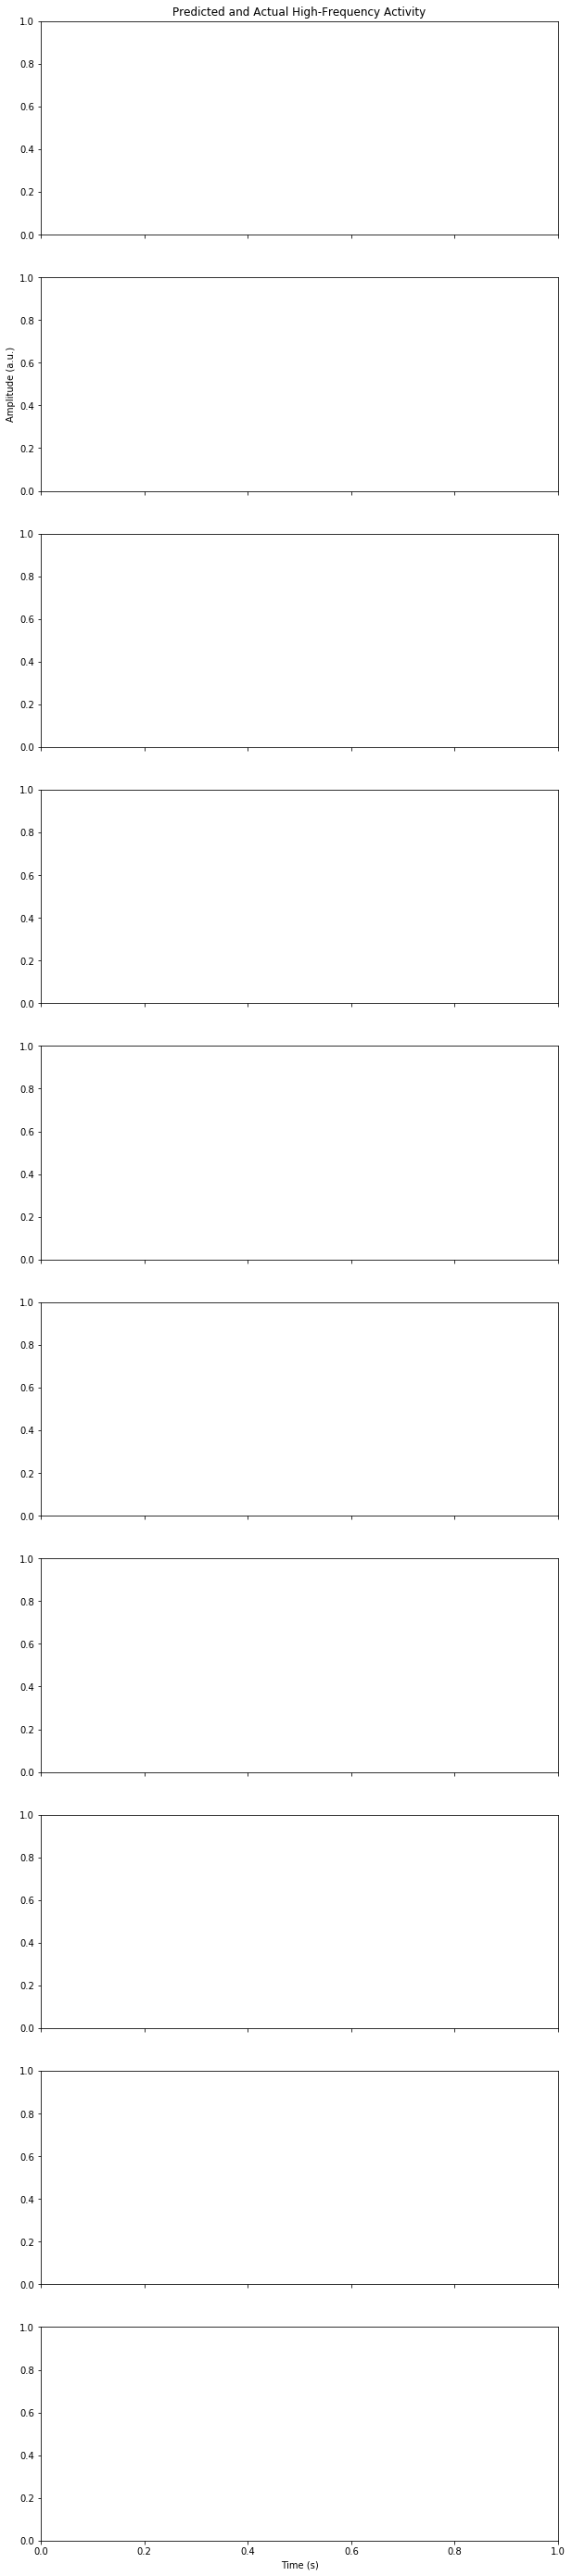

In [4]:
## Import list of subjects
for si in range(0,s_list.shape[0]):
    ## Stim features
    data = pd.read_csv('/Volumes/LBCN8T_2/Stanford/data/encoding/' + str(s_list['name'][si]) + '_stim_features.csv')
    data.head()

    ## Recode task name
    data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 2
    data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1

    ## Brain features
    # Set extreme values to zero (double check spike exclusion)
    #data = np.genfromtxt('/Volumes/LBCN8T_2/Stanford/data/encoding/57_brain_features.csv', delimiter=',')
    #data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
    y_tmp = pd.read_csv('/Volumes/LBCN8T_2/Stanford/data/encoding/' + str(s_list['name'][si]) + '_brain_features.csv', header=None)
    y = y_tmp.to_numpy()
    y[y>30]=0 # Set extreme values to 0
    ## log transform y
    #y = np.log(np.abs(y+1))   
    #y[np.isinf(y)] = 0
    # Filter trials
    good_trials = (data.loc[:,'task_general_cond_name'] == 1) | (data.loc[:,'task_general_cond_name'] == 2)
    y = y[good_trials,:]
    data = data.loc[good_trials,:]

    # Define trials
    times = np.shape(np.unique(data.loc[:,'time']))
    times = int(times[0])
    r,c = np.shape(data)
    trials = int(r/times)
    trials_rs = np.matlib.repmat(np.arange(1,trials+1),times,1).T
    trials_rs = trials_rs.reshape(-1,1)
    data['trials'] = trials_rs

    # Select features
    features = np.array(data.loc[:,'task_general_cond_name'])

    # Reshape features
    features_reshape = np.reshape(features, (trials, times))
    features_reshape = np.expand_dims(features_reshape, axis=1)

    # Add delayed features
    fs = 500
    time_window = 0.02;
    #n_delays = 100
    #delays = np.linspace(1, 2, 100)

    start = 0; stop = 2; step = time_window
    delays = np.arange(start, stop+step, step)
    n_delays = int(len(delays))

    X_delayed = np.zeros((trials,1,n_delays,times))
    for i in range(trials):
        for ii in range(n_delays):
            window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
            X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))

    # Concatenate back the delayed features
    X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
    X = np.hstack(X_env).T

    # We'll use the KFold iterator, shuffling trial numbers first
    cross_val_iterator = cv.KFold(trials, n_folds=10, shuffle=True)
    model = Ridge(alpha=1e5)


    fig, axs = plt.subplots(len(cross_val_iterator), 1,
                            figsize=(10, 5*len(cross_val_iterator)),
                            sharex=True)
    axs[0].set_title('Predicted and Actual High-Frequency Activity')
    axs[1].set_ylabel('Amplitude (a.u.)')
    axs[-1].set_xlabel('Time (s)')

    scores_all = np.zeros([y.shape[1], cross_val_iterator.n_folds])
    coefs_all = np.zeros([y.shape[1], X.shape[1], cross_val_iterator.n_folds])
    intercept_all = np.zeros([y.shape[1], cross_val_iterator.n_folds])

    scores_cv = np.zeros(y.shape[1])

    counter = 0
    for ax, (tr, tt) in zip(axs, cross_val_iterator):
        # Pull the training / testing data for the ecog data
        y_tr = y[data['trials'].isin(tr)]
        y_tt = y[data['trials'].isin(tt)]

        # Pull the training / testing data for the spectrogram
        X_tr = X[data['trials'].isin(tr)]
        X_tt = X[data['trials'].isin(tt)]

        # Scale all the features for simplicity
        X_tr = scale(X_tr)
        X_tt = scale(X_tt)
        y_tr = scale(y_tr)
        y_tt = scale(y_tt)

        # Fit the model, and use it to predict on new data
        model.fit(X_tr, y_tr)
        predictions = model.predict(X_tt)

        # Get the average (R2)
        # Get the average (R2)
        for i in range(0, y.shape[1]):
            scores_cv[i] = r2_score(y_tt[:,i], predictions[:,i])

        scores_all[:,counter] = scores_cv
        coefs_all[:,:,counter] = model.coef_
        intercept_all[:,counter] = model.intercept_
        counter = counter + 1

    scores_all = np.mean(scores_all, axis=1)
    coefs_all = np.mean(coefs_all, axis=2)
    intercept_all = np.mean(intercept_all, axis=1)
    #np.savetxt('/Volumes/LBCN8T_2/Stanford/data/encoding/' + str(s_list['name'][si]) + '_scores.csv', scores_all, delimiter=',')
    np.savetxt('/Volumes/LBCN8T_2/Stanford/data/encoding/' + str(s_list['name'][si]) + '_scores.csv', scores_all, delimiter=',')
    np.savetxt('/Volumes/LBCN8T_2/Stanford/data/encoding/' + str(s_list['name'][si]) + '_coefs.csv', coefs_all, delimiter=',')
    np.savetxt('/Volumes/LBCN8T_2/Stanford/data/encoding/' + str(s_list['name'][si]) + '_intercept.csv', intercept_all, delimiter=',')


In [ ]:
model.intercept_.shape

In [ ]:
coefs_all = np.zeros([y.shape[1], X.shape[1], cross_val_iterator.n_folds])



In [90]:
coefs_all.shape

(118, 76, 10)